# Section 0: Import section

In [1]:
# pytorch 
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset
from torchtext.vocab import GloVe
from torch.utils.data import DataLoader, TensorDataset
import torchvision.transforms


# data science
import pandas as pd
import numpy as np
from numpy import savetxt
from numpy import loadtxt
from sentence_transformers import SentenceTransformer
import pandas as pd

# scikit-learn
import sklearn
from sklearn.metrics import classification_report


# python standard library
import math
import time
import csv
import random

# helper classes and functions
from helper_func_and_classes import create_dataset_list, create_submission_file
from helper_func_and_classes import output_numpy_array_from_model_training
from helper_func_and_classes import get_count_of_longest_sentence
from helper_func_and_classes import create_data_loader_MiniLM
from helper_func_and_classes import TwitterDataset, NN_se


# other
from tqdm import tqdm
import matplotlib.pyplot as plt

RANDOM_SEED = 123
random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED);


# Section 1: Data preprocessing section
## Section 1.1: Creating lists of sentences

In [2]:
pos_data = create_dataset_list("./twitter-datasets/train_pos_full.txt")
neg_data = create_dataset_list("./twitter-datasets/train_neg_full.txt")

submission_data = create_dataset_list("./twitter-datasets/test_data.txt")

print("Length of submission_data: ",len(submission_data))

Length of submission_data:  10000


## Section 1.2: Sentence embeddings
In this section we will load in the sentence model from huggingface and encode the sentences. This part is pretty compute intensive and will take around 7-8 hours to finish. So to speed up this process, the embeddings have already been created and written to file. Change `sentence_transformer_created = False` to redo the encoding and write to file.

source: https://huggingface.co/sentence-transformers/all-mpnet-base-v2

In [3]:
sentence_transformer_created = True

if not sentence_transformer_created:
    level_1_sentence_transformer = 'sentence-transformers/all-MiniLM-L6-v2'
    sentence_model = SentenceTransformer(level_1_sentence_transformer)

In [4]:
if not sentence_transformer_created:
    print("pos_data length: ", len(pos_data))
    print("neg_data length: ", len(neg_data))
    print("submission_data length: ", len(submission_data))
    full_data_list = pos_data + neg_data + submission_data
    sentence_embeddings = sentence_model.encode(full_data_list, batch_size=256, show_progress_bar=True)

### Section 1.2.1: Writing sentence embeddings to file

In [5]:
# saving word embeddings to file type 'sentence-transformers/all-MiniLM-L6-v2'
if not sentence_transformer_created:
    savetxt('./word_embeddings/full_full_data_list_sentence_embeddings.csv', sentence_embeddings, delimiter=',')


### Section 1.2.2: Reading sentence embeddings from file

In [6]:
numb_rows, numb_cols = 2510000, 384
chunk_rows = 10000
filepath_sentence_embed = './word_embeddings/full_full_data_list_sentence_embeddings.csv'
## read it back

# Replace np.empty by np.memmap array for large datasets.
full_data_list_sentence_embeddings = np.empty((numb_rows, numb_cols), dtype=np.float32)
current_index = 0
chunks = pd.read_csv(filepath_sentence_embed, chunksize=chunk_rows)
for chunk in tqdm(chunks):
    m, _ = chunk.shape
    full_data_list_sentence_embeddings[current_index:current_index+m, :] = chunk
    current_index += m


251it [03:03,  1.37it/s]


In [7]:
pos_data_sentence_embeddings = full_data_list_sentence_embeddings[:1250000].astype(np.float32)
neg_data_sentence_embeddings = full_data_list_sentence_embeddings[1250000:2500000].astype(np.float32)
submission_data_sentence_embeddings = full_data_list_sentence_embeddings[2500000:2500000+10000].astype(np.float32)

# Section 2: Neural network

## Sentence embeddings

In [8]:
# Sentence embeddings
batch_size = 32
test_size = 0.1
train_loader, train_loader_lite,test_loader,test_loader_lite,train_labels,train_labels_lite,test_labels, test_labels_lite = create_data_loader_MiniLM(
    pos_data_sentence_embeddings,
    neg_data_sentence_embeddings,
    batch_size,
    test_size=test_size)

Number of elements in train_data is:  2250000
Number of elements in test_data is:  250000


## Section 2.1: Choosing best parameters

In [9]:
# Finding best parameters for neural network
epoch_options = [5, 10]
lr_options = [1e-4, 1e-3, 1e-2, 1e-1]
drop_options = [0, 0.1, 0.45, 0.55, 0.65]
input_dim_opt = 384
num_classes = 2

all_options = []
for i in epoch_options:
    for j in lr_options:
        for k in drop_options:
             all_options.append([i,j,k])
                
precision_list = []
recall_list = []
f1score_list = []
support_list = []

In [10]:
%%time

for epoch_i, lr_i, drop_i in all_options:
    start_time = time.time()
    print(f"Epoch: {epoch_i} | Learning rate: {lr_i} | Dropout probability: {drop_i}")
    
    model = NN_se(input_size=input_dim_opt, num_classes=num_classes, p=drop_i)
    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=lr_i)
    for epoch in range(epoch_i):
        for data, labels in train_loader_lite:

            model_score = model(data)
            loss = criterion(model_score, labels)
            optimizer.zero_grad()

            loss.backward()

            optimizer.step()
    
    
    # creating status report for current iteration
    predicted_labels = output_numpy_array_from_model_training(test_loader_lite, model)
    
    class_report = classification_report(test_labels_lite, predicted_labels, output_dict=True)['macro avg']
    
    # appending results to corresponding list
    precision_list.append(class_report['precision'])
    recall_list.append(class_report['recall'])
    f1score_list.append(class_report['f1-score'])
    support_list.append(class_report['support'])
    print("Time of current iteration: ", time.time()-start_time)
    print(class_report, "\n")

Epoch: 5 | Learning rate: 0.0001 | Dropout probability: 0
Time of current iteration:  61.54925203323364
{'precision': 0.7996814735996849, 'recall': 0.7995629185160427, 'f1-score': 0.7995699720542453, 'support': 12500} 

Epoch: 5 | Learning rate: 0.0001 | Dropout probability: 0.1
Time of current iteration:  65.09728002548218
{'precision': 0.7993326811633275, 'recall': 0.7984520128911543, 'f1-score': 0.7983871535971023, 'support': 12500} 

Epoch: 5 | Learning rate: 0.0001 | Dropout probability: 0.45
Time of current iteration:  59.931012868881226
{'precision': 0.8006061249464476, 'recall': 0.7998183597366062, 'f1-score': 0.799765695921153, 'support': 12500} 

Epoch: 5 | Learning rate: 0.0001 | Dropout probability: 0.55
Time of current iteration:  63.5243821144104
{'precision': 0.8033141471942715, 'recall': 0.8030650079218011, 'f1-score': 0.8030659940785938, 'support': 12500} 

Epoch: 5 | Learning rate: 0.0001 | Dropout probability: 0.65
Time of current iteration:  61.560884952545166
{'pre

Time of current iteration:  151.56557989120483
{'precision': 0.7978674410850998, 'recall': 0.7447256431240896, 'f1-score': 0.7334762731928948, 'support': 12500} 

Epoch: 10 | Learning rate: 0.1 | Dropout probability: 0.55
Time of current iteration:  150.90954685211182
{'precision': 0.7932016393388532, 'recall': 0.7911926488635042, 'f1-score': 0.7909640879893967, 'support': 12500} 

Epoch: 10 | Learning rate: 0.1 | Dropout probability: 0.65
Time of current iteration:  133.91695094108582
{'precision': 0.7742613822680426, 'recall': 0.6877147877170303, 'f1-score': 0.6618016919773504, 'support': 12500} 

CPU times: user 1h 16min 22s, sys: 34min 2s, total: 1h 50min 24s
Wall time: 1h 5min 49s


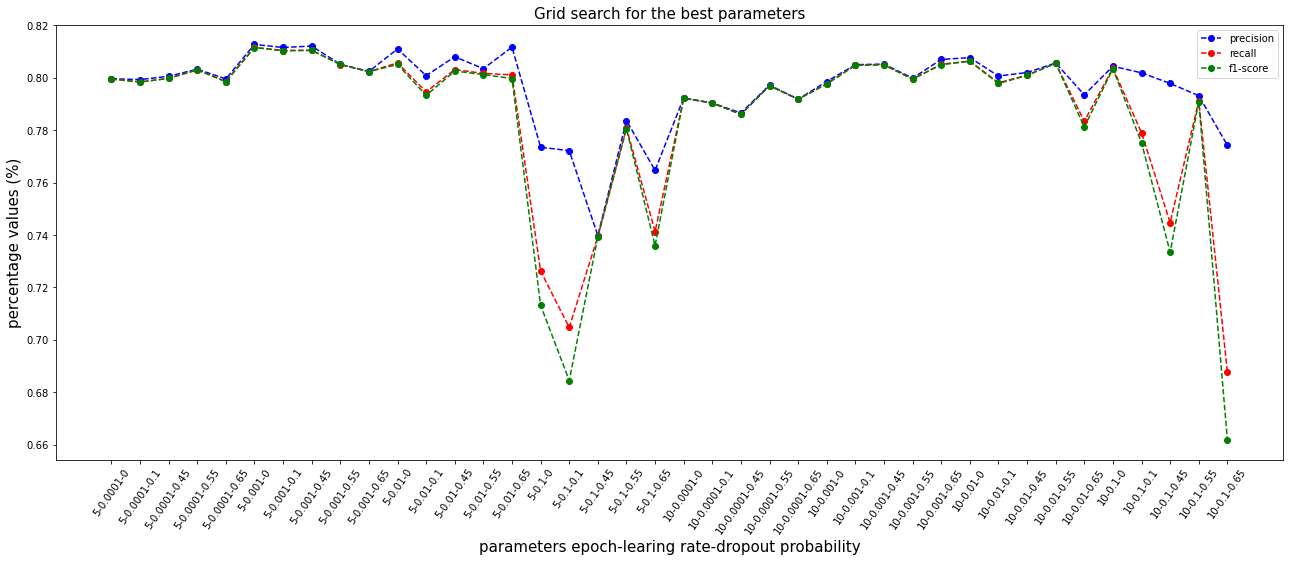

In [12]:
all_options_str = [f"{a}-{b}-{c}" for a,b,c in all_options]


plt.rcParams["figure.figsize"] = (22,8)

plt.xticks(rotation='55', fontsize=10)
plt.plot(all_options_str, precision_list, linestyle='--', marker='o', color='blue', label='precision')
plt.plot(all_options_str, recall_list, linestyle='--', marker='o', color='red', label='recall')
plt.plot(all_options_str, f1score_list, linestyle='--', marker='o', color='green', label='f1-score')
plt.title("Grid search for the best parameters", fontsize=15)
plt.xlabel("parameters epoch-learing rate-dropout probability", fontsize=15)
plt.ylabel("percentage values (%)", fontsize=15)

plt.legend()
plt.show();

In [13]:
input_dim = 384
num_classes = 2
learning_rate = 0.01 
num_epoch = 5
drop_probability = 0.55


In [14]:
model = NN_se(input_size=input_dim, num_classes=num_classes, p=drop_probability)
criterion = nn.CrossEntropyLoss()

optimizer = Adam(model.parameters(), lr=learning_rate)
for epoch in range(num_epoch):
    for data, labels in tqdm(train_loader):

        model_score = model(data)
        loss = criterion(model_score, labels)
        optimizer.zero_grad()

        loss.backward()

        optimizer.step()
    
predicted_labels = output_numpy_array_from_model_training(test_loader, model)
print(sklearn.metrics.classification_report(test_labels, predicted_labels))

100%|███████████████████████████████████████████████████████████| 70313/70313 [03:56<00:00, 297.49it/s]


              precision    recall  f1-score   support

           0       0.82      0.83      0.83    124929
           1       0.83      0.82      0.83    125071

    accuracy                           0.83    250000
   macro avg       0.83      0.83      0.83    250000
weighted avg       0.83      0.83      0.83    250000



In [17]:
predicted_labels = output_numpy_array_from_model_training(test_loader, model)
print(classification_report(test_labels, predicted_labels, digits=4))

              precision    recall  f1-score   support

           0     0.8241    0.8277    0.8259    124929
           1     0.8272    0.8236    0.8254    125071

    accuracy                         0.8256    250000
   macro avg     0.8256    0.8256    0.8256    250000
weighted avg     0.8256    0.8256    0.8256    250000



### Specific for sentence embeddings

In [15]:
# sentence embeddings submission
submission_data_sentence_embeddings_tensor = torch.tensor(submission_data_sentence_embeddings).type(torch.float)
id_submit = torch.tensor(np.arange(0,10000)).type(torch.float)

In [16]:
submission_dataset = TensorDataset(submission_data_sentence_embeddings_tensor, id_submit)
submission_loader = DataLoader(dataset=submission_dataset, batch_size=batch_size,  shuffle=False)


submission_numpy_array = output_numpy_array_from_model_training(submission_loader, model)
submission_numpy_array

array([1., 0., 1., ..., 1., 0., 0.])

In [ ]:
create_submission_file(submission_numpy_array)